In [1]:
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [4]:
from transformers import BertTokenizerFast, BertModel, AdamW, get_linear_schedule_with_warmup

In [5]:
from project_path import project_path
project_path(1)

d:\Users\Nicholas\Projects\NLP\long_texts


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, precision_recall_fscore_support

In [7]:
# import from src
import src.models.models as models
import src.models.data_loader as data_loader
import src.models.training as training
import src.features.preprocess as preprocess

In [8]:
import pickle

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [11]:
# if gpu is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
# data directories
proj_dir = Path.cwd().parents[0]
data_raw = Path(proj_dir, 'data', 'raw')

In [13]:
PRE_TRAINED_MODEL_NAME = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
data = pd.read_csv(Path(data_raw, 'IMDB Dataset.csv'))

In [15]:
data['tokens'] = data['review'].progress_apply(tokenizer.tokenize)
data['n_tokens'] = data['tokens'].apply(len)

100%|██████████| 50000/50000 [00:50<00:00, 981.51it/s]


In [16]:
# take data with long strings only
data = data.loc[data['n_tokens'] > 700, :]

In [17]:
data['target'] = (data['sentiment'] == 'positive').astype(int)

In [18]:
data.shape

(4024, 5)

In [19]:
# Subsample
# data_sample, _ = train_test_split(data, train_size=0.01, random_state=RANDOM_SEED, shuffle=True, stratify=data['target'])
data_sample = data.copy()
data_sample = data_sample.rename(columns = {'review':'content'})
data_sample = data_sample.drop(['tokens', 'n_tokens'], axis=1)

In [20]:
data_sample.shape

(40, 3)

#### Train test split

In [21]:
df_train, df_test = train_test_split(
    data_sample, 
    train_size=0.8, 
    random_state=RANDOM_SEED, 
    shuffle=True,
    stratify=data_sample['target'])

In [22]:
df_val, df_test = train_test_split(
    df_test, 
    train_size=0.5, 
    random_state=RANDOM_SEED, 
    shuffle=True, 
    stratify=df_test['target'])

In [23]:
print(df_train.shape, df_val.shape, df_test.shape)

(32, 3) (4, 3) (4, 3)


In [24]:
print(df_train.target.value_counts(normalize = True))

1    0.5625
0    0.4375
Name: target, dtype: float64


#### Train model

In [25]:
model_dir = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"

In [26]:
model_config = {
    'n_classes':2, 
    'add_linear':[512,256], 
    'attn_bias':False, 
    'freeze_layer_count':8
}

In [27]:
trainer = training.Trainer(model_dir, model_config)

Some weights of the model checkpoint at D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1 were not used when initializing HIBERT: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing HIBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HIBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HIBERT were n

In [28]:
import inspect

signature = inspect.signature(trainer.__init__)

for param in signature.parameters.values():
    print(param)

model_dir
model_config
max_len=2048
epochs=4
out_dir=None
device='cpu'
loss_fn='cross_entropy_loss'
optimizer='adamw'
lr=1e-05
scheduler='linear_schedule_with_warmup'
train_batch_size=32
val_batch_size=32
test_batch_size=32
chunksize=512
sampler=None


In [29]:
for name, param in trainer.model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [30]:
trainer.fit(df_train, df_val)

Epoch 1 / 4
--------------------
Batch Train loss: 0.6933     Class 1 prop: 0.5625     ACC: 0.6562     F1: 0.7556     AUC: 0.7901

Epoch Train loss: 0.6933     Class 1 prop: 0.5625     ACC: 0.6562     F1: 0.7556     AUC: 0.7901
Epoch val   loss: 0.6921     Class 1 prop: 0.5000     ACC: 0.5000     F1: 0.6667     AUC: 1.0000

Epoch 2 / 4
--------------------
Batch Train loss: 0.6924     Class 1 prop: 0.5625     ACC: 0.7500     F1: 0.8000     AUC: 0.8339

Epoch Train loss: 0.6924     Class 1 prop: 0.5625     ACC: 0.7500     F1: 0.8000     AUC: 0.8339
Epoch val   loss: 0.6919     Class 1 prop: 0.5000     ACC: 0.5000     F1: 0.6667     AUC: 1.0000

Epoch 3 / 4
--------------------
Batch Train loss: 0.6914     Class 1 prop: 0.5625     ACC: 0.7500     F1: 0.8095     AUC: 0.8052

Epoch Train loss: 0.6914     Class 1 prop: 0.5625     ACC: 0.7500     F1: 0.8095     AUC: 0.8052
Epoch val   loss: 0.6919     Class 1 prop: 0.5000     ACC: 0.5000     F1: 0.6667     AUC: 1.0000

Epoch 4 / 4
----------

#### plot history

In [31]:
history = trainer.history

In [32]:
epochs = len(history['train_loss'])

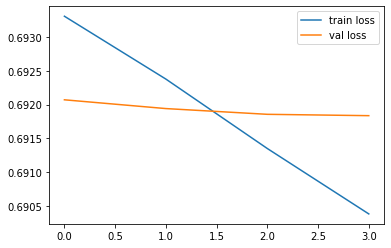

In [33]:
plt.plot(list(range(epochs)), history['train_loss'], label = 'train loss')
plt.plot(list(range(epochs)), history['val_loss'], label = 'val loss')
plt.legend()

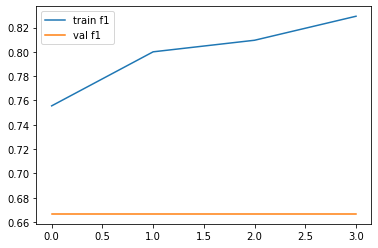

In [34]:
plt.plot(list(range(epochs)), history['train_f1'], label = 'train f1')
plt.plot(list(range(epochs)), history['val_f1'], label = 'val f1')
plt.legend()

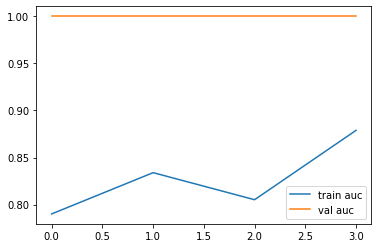

In [35]:
plt.plot(list(range(epochs)), history['train_auc'], label = 'train auc')
plt.plot(list(range(epochs)), history['val_auc'], label = 'val auc')
plt.legend()

#### make predictions

In [47]:
pred_dict = trainer.predict(df_test)

In [48]:
pred_dict

{'target': [0, 0, 1, 1],
 'pred_proba': [0.5070345401763916,
  0.5076051354408264,
  0.5072532892227173,
  0.5072005987167358],
 'pred': [1, 1, 1, 1],
 'attn_wts': [array([0.0006811 , 0.00064663, 0.00066243, ..., 0.00062783, 0.00057426,
         0.00056775], dtype=float32),
  array([0.0006714 , 0.00072512, 0.00073024, ..., 0.00056763, 0.00055965,
         0.00071509], dtype=float32),
  array([0.00064149, 0.00064297, 0.00070829, ..., 0.00054882, 0.00056335,
         0.00069222], dtype=float32),
  array([0.00096511, 0.0009059 , 0.00110598, ..., 0.0008956 , 0.00090181,
         0.00098027], dtype=float32)],
 'input_ids': [array([ 101,  178, 2542, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1191, 1128, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 2523, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 1110, ...,    0,    0,    0], dtype=int64)]}

In [49]:
df_test_ = df_test.drop('target', axis=1)

In [50]:
pred_dict_ = trainer.predict(df_test_)

In [51]:
pred_dict_

{'target': [nan, nan, nan, nan],
 'pred_proba': [0.5070345401763916,
  0.5076051354408264,
  0.5072532892227173,
  0.5072005987167358],
 'pred': [1, 1, 1, 1],
 'attn_wts': [array([0.0006811 , 0.00064663, 0.00066243, ..., 0.00062783, 0.00057426,
         0.00056775], dtype=float32),
  array([0.0006714 , 0.00072512, 0.00073024, ..., 0.00056763, 0.00055965,
         0.00071509], dtype=float32),
  array([0.00064149, 0.00064297, 0.00070829, ..., 0.00054882, 0.00056335,
         0.00069222], dtype=float32),
  array([0.00096511, 0.0009059 , 0.00110598, ..., 0.0008956 , 0.00090181,
         0.00098027], dtype=float32)],
 'input_ids': [array([ 101,  178, 2542, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1191, 1128, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 2523, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 1110, ...,    0,    0,    0], dtype=int64)]}

#### load up trained model

In [44]:
trained = training.Trainer('trained_model', model_config)

In [45]:
pred_dict = trained.predict(df_test)
pred_dict

{'target': [0, 0, 1, 1],
 'pred_proba': [0.49931150674819946,
  0.5003823637962341,
  0.500227689743042,
  0.4995160400867462],
 'pred': [0, 1, 1, 0],
 'attn_wts': [array([0.00068217, 0.00064994, 0.00066508, ..., 0.00062576, 0.00057271,
         0.00056626], dtype=float32),
  array([0.00067093, 0.00072801, 0.00073458, ..., 0.00056632, 0.00055851,
         0.00071465], dtype=float32),
  array([0.00064354, 0.00064437, 0.00070839, ..., 0.00054672, 0.00056119,
         0.00069235], dtype=float32),
  array([0.00096471, 0.00090967, 0.00110699, ..., 0.0008922 , 0.00090006,
         0.00098046], dtype=float32)],
 'input_ids': [array([ 101,  178, 2542, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1191, 1128, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 2523, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 1110, ...,    0,    0,    0], dtype=int64)]}

In [46]:
pred_dict_ = trained.predict(df_test_)
pred_dict_

{'target': [nan, nan, nan, nan],
 'pred_proba': [0.49931150674819946,
  0.5003823637962341,
  0.500227689743042,
  0.4995160400867462],
 'pred': [0, 1, 1, 0],
 'attn_wts': [array([0.00068217, 0.00064994, 0.00066508, ..., 0.00062576, 0.00057271,
         0.00056626], dtype=float32),
  array([0.00067093, 0.00072801, 0.00073458, ..., 0.00056632, 0.00055851,
         0.00071465], dtype=float32),
  array([0.00064354, 0.00064437, 0.00070839, ..., 0.00054672, 0.00056119,
         0.00069235], dtype=float32),
  array([0.00096471, 0.00090967, 0.00110699, ..., 0.0008922 , 0.00090006,
         0.00098046], dtype=float32)],
 'input_ids': [array([ 101,  178, 2542, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1191, 1128, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 2523, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1142, 1110, ...,    0,    0,    0], dtype=int64)]}